## First Attempt at building a deepsets architecture

In [36]:
import random

import pandas as pd
import numpy as np
import pickle

from numpy import NaN

from lightning import LitVarDeepSet, DeepDataModule
from set_dataloader import CCD
import time

# Import NN Packages
import torch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

print(torch.__version__)

from models import VarMultiSetNet
from util import get_dataset, get_mask


1.9.0


In [37]:
gal = 'qso'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
num_pixels = 20000
max_set_len = 30
path_to_data = '../../bricks_data/multiset.pickle'
traindata, valdata = get_dataset(num_pixels=num_pixels, max_set_len=max_set_len,
                                 gal=gal,
                                 path_to_data=path_to_data)

valloader = DataLoader(
    valdata, batch_size=128, shuffle=False, drop_last=True, num_workers=0)

best_score = 0
best_file = ""
for filename in os.listdir(f'trained_models/{gal}/'):
    if "nan" in filename:
        os.remove(f'trained_models/{gal}/{filename}')
        continue

    # all init args were saved to the checkpoint
    #checkpoint = torch.load(f'trained_models/{gal}/{filename}')
    #print(checkpoint['hyper_parameters'])

    model = LitVarDeepSet.load_from_checkpoint(checkpoint_path=f'trained_models/{gal}/{filename}',
                                               hmap_location=torch.device('cpu'))
    model.eval()
    y_pred = np.array([])
    y_gold = np.array([])

    with torch.no_grad():
        for i, (X1, X2, labels, set_sizes) in enumerate(valloader):
            # Extract inputs and associated labels from dataloader batch
            X1 = X1.to(device)

            X2 = X2.to(device)

            labels = labels.to(device)

            set_sizes = set_sizes.to(device)

            mask = get_mask(set_sizes, X1.shape[2])
            # Predict outputs (forward pass)

            predictions = model(X1, X2, mask=mask)
            # Predict outputs (forward pass)

            # Get predictions and append to label array + count number of correct and total
            y_pred = np.append(y_pred, predictions.cpu().detach().numpy())
            y_gold = np.append(y_gold, labels.cpu().detach().numpy())

        print(len(y_pred))
        r2 = metrics.r2_score(y_gold, y_pred)
        if r2 > best_score:
            best_score = r2
            best_file = filename
        print(filename, "R-2", r2)

print("Best Validation Set R-Squared: ", best_score)
print("Filename: ", best_file)
print("Best Model: ")

checkpoint = torch.load(f'trained_models/{gal}/{best_file}', map_location=torch.device('cpu'))
print(checkpoint['hyper_parameters']['model'])

#Clean-Up all unnecessary models
for filename in os.listdir(f'trained_models/{gal}/'):
    if filename == best_file:
        continue
    os.remove(f'trained_models/{gal}/{filename}')

6400
Val_loss=0.0864.ckpt R-2 0.7168382883831987
6400
Val_loss=0.1429.ckpt R-2 0.32612371680268437
6400
Val_loss=0.3350.ckpt R-2 -2.3251484338884545
6400
Val_loss=0.0874.ckpt R-2 0.7095262906684832
6400
Val_loss=0.0143.ckpt R-2 0.7042203408124708
6400
Val_loss=0.1800.ckpt R-2 0.04358960218156993
6400
Val_loss=0.1118.ckpt R-2 0.5438152389356572
6400
Val_loss=0.3350-v1.ckpt R-2 -2.3251484338884545
6400
Val_loss=0.0871.ckpt R-2 0.7149399414464737
Best Validation Set R-Squared:  0.7168382883831987
Filename:  Val_loss=0.0864.ckpt
Best Model: 


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Testing Performance of Trained Model


In [61]:
feature_extractor = nn.Sequential(
    nn.Linear(15, 224),
    nn.ReLU(inplace=False),
    nn.Linear(224, 219),
    nn.ReLU(inplace=False),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(219, 50),
    nn.ReLU(inplace=False)
)

mlp = nn.Sequential(
    nn.Linear(64 + 2, 247),
    nn.ReLU(inplace=False),
    nn.Linear(247, 198),
    nn.ReLU(inplace=False),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(198, 35),
    nn.ReLU(inplace=False),
    nn.Linear(35, 1),
    nn.ReLU(inplace=False)
)

lr = 0.00011649895667343224
criterion = nn.L1Loss()
batch_size = 16
no_epochs = 130

model = VarMultiSetNet(feature_extractor=feature_extractor, mlp=mlp,
                       med_layer=50, reduction='sum')

In [62]:
torch.save(model, "trained_models/{}.pt".format(14))

In [ ]:
model = torch.load('trained_models/14.pt', map_location=torch.device('cpu'))

max_set_len = 30
gal = 'qso'
traindata, valdata = get_dataset(num_pixels=3000, max_set_len=max_set_len, gal=gal)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
num_workers = 0 if device == 'cpu:0' else 8

In [ ]:


print(f" | Model params: {sum(p.numel() for p in model.parameters() if p.requires_grad)} |")

print()
optimiser = optim.Adam(model.parameters(), lr=lr)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, drop_last=False)

mse, r2 = 0, 0

for epoch in range(no_epochs):

    model.train()

    for i, (X1, X2, labels, set_sizes) in enumerate(trainloader):
        # Extract inputs and associated labels from dataloader batch
        X1 = X1.to(device)

        X2 = X2.to(device)

        labels = labels.to(device)

        set_sizes = set_sizes.to(device)

        mask = get_mask(set_sizes, X1.shape[2])
        # Predict outputs (forward pass)

        predictions = model(X1, X2, mask=mask)

        # Zero-out the gradients before backward pass (pytorch stores the gradients)

        optimiser.zero_grad()

        # Compute Loss
        loss = criterion(predictions, labels)

        # Backpropagation
        loss.backward()

        # Perform one step of gradient descent
        optimiser.step()

    model.eval()
    y_pred = np.array([])
    y_gold = np.array([])

    with torch.no_grad():
        for i, (X1, X2, labels, set_sizes) in enumerate(valloader):
            # Extract inputs and associated labels from dataloader batch
            X1 = X1.to(device)

            X2 = X2.to(device)

            labels = labels.to(device)

            set_sizes = set_sizes.to(device)

            mask = get_mask(set_sizes, X1.shape[2])
            # Predict outputs (forward pass)

            predictions = model(X1, X2, mask=mask)
            # Predict outputs (forward pass)

            # Get predictions and append to label array + count number of correct and total
            y_pred = np.append(y_pred, predictions.cpu().detach().numpy())
            y_gold = np.append(y_gold, labels.cpu().detach().numpy())

    try:
        r2 = metrics.r2_score(y_gold, y_pred)
        mse = metrics.mean_squared_error(y_gold, y_pred)
    except:
        print("++++++++++++++++++++")
        print("        NaN         ")
        print("++++++++++++++++++++")

    print("Epoch: ", epoch)
    print("R-2: ", r2)
    print("MSE: ", mse)
    print()
    # Handle pruning based on the intermediate value.

torch.save(model, "trained_models/{}.pt".format(14))


In [ ]:
print('++++++++ Session Characteristics +++++++')
print()
print(f"Gal Type: {gal}")
print(f"Training Samples: {traindata.num_pixels}")
print(f"Validation Samples: {valdata.num_pixels}")
print(f"Maximum Set Lengths: {max_set_len}")
print(f"Device: {device}")
print(f"Number of Workers: {num_workers}")
print()
print('+++++++++++++++++++++++++++++++++++++++')

In [ ]:
model = torch.load('trained_models/14.pt', map_location=torch.device('cpu'))

max_set_len = 30
gal = 'qso'
batch_size
traindata, valdata = get_dataset(num_pixels=20000, max_set_len=max_set_len, gal=gal)

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, drop_last=False)

mse, r2 = 0, 0

device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'
num_workers = 0 if device == 'cpu:0' else 8
print(f"Training Samples: {traindata.num_pixels}")
print(f"Validation Samples: {valdata.num_pixels}")


In [ ]:
model.eval()
y_pred = np.array([])
y_gold = np.array([])
y_set_sizes = np.array([])
x2 = np.array([])

with torch.no_grad():
    for i, (X1, X2, labels, set_sizes) in enumerate(trainloader):
        # Extract inputs and associated labels from dataloader batch
        X1 = X1.to(device)

        X2 = X2.to(device)

        labels = labels.to(device)

        set_sizes = set_sizes.to(device)

        mask = get_mask(set_sizes, X1.shape[2])
        # Predict outputs (forward pass)

        predictions = model(X1, X2, mask=mask)
        # Predict outputs (forward pass)

        # Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, predictions.cpu().detach().numpy())
        y_gold = np.append(y_gold, labels.cpu().detach().numpy())
        y_set_sizes = np.append(y_set_sizes, set_sizes.cpu().detach().numpy())
        x2 = np.append(x2, X2.cpu().detach().numpy())

    r2 = metrics.r2_score(y_gold, y_pred)
    mse = metrics.mean_squared_error(y_gold, y_pred)

    diff = y_gold - y_pred

print("R-2: ", r2)
print("MSE: ", mse)
print(diff)


In [ ]:
path_to_data = '../../bricks_data/multiset.pickle'
with open(path_to_data, 'rb') as f:
    mini_multiset = pickle.load(f)
    f.close()
df = pd.DataFrame.from_dict(mini_multiset, orient='index')
train_df, test_df = train_test_split(df, test_size=0.33, random_state=99, shuffle=True)

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
df.describe()

In [ ]:
zscore = lambda x: abs((x - x.median()) / x.std())
df['Z_LRG'] = df[2].transform(zscore)
df['Z_ELG'] = df[3].transform(zscore)
df['Z_QSO'] = df[4].transform(zscore)

df.describe()

In [ ]:
print(df.shape)
df = df[(df['Z_LRG'] < 3)]
print(df.shape)
df = df[(df['Z_ELG'] < 3)]
print(df.shape)
df = df[(df['Z_QSO'] < 3)]
print(df.shape)

In [ ]:
df.drop(columns=['Z_ELG', 'Z_LRG', 'Z_QSO'], inplace=True)
df.describe()


In [3]:

from util import get_dataset

traindata, valdata = get_dataset(num_pixels=20000, max_set_len=30, gal='qso')

trainloader = torch.utils.data.DataLoader(traindata, batch_size=16, shuffle=True,
                                          num_workers=0, drop_last=False)

valloader = torch.utils.data.DataLoader(valdata, batch_size=16, shuffle=False, drop_last=False)

In [4]:
d = trainloader.dataset[:]

In [5]:
x1, x2, train_labels, set_sizes = d

print(x1.shape)
print(x2.mean(axis=0))
print(train_labels.mean())
print(set_sizes.mean())

torch.Size([13204, 64, 30, 15])
tensor([0.0755, 0.0827])
tensor(0.3341)
14.805192791956983


In [6]:
d = valloader.dataset[:]

In [7]:
x1, x2, test_labels, set_sizes = d

print(x1.shape)
print(x2.mean(axis=0))
print(test_labels.mean())
print(set_sizes.mean())

torch.Size([6505, 64, 30, 15])
tensor([0.0737, 0.0825])
tensor(0.3349)
14.788465603382013


In [8]:
import matplotlib.pyplot as plt

In [9]:
print(train_labels.numpy().flatten().shape)

(13204,)


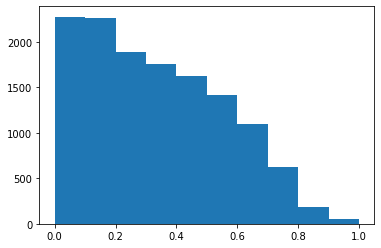

In [10]:
train_labels = train_labels.numpy().flatten()
plt.hist(train_labels, range=[0, 1])
plt.show()

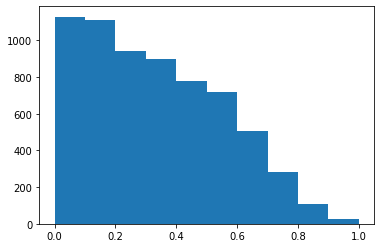

In [11]:
test_labels = test_labels.numpy().flatten()
plt.hist(test_labels, range=[0, 1])
plt.show()


In [ ]:
shared = np.append(train_labels, test_labels)
print(len(shared))
plt.hist(shared)
plt.show()

In [ ]:
diff = np.abs(diff)

print(diff.mean())
print(np.median(diff))
print(diff.max())

In [ ]:
diff = np.abs(diff)

print(diff.mean())
print(np.median(diff))
print(diff.max())



## Building a deepsets architecture


## Writing Dataset Utility to pass data in the right format

#### Steps:

1. Build a NN sampling an equal number of CCDs per 256 pixel and pass through deep sets for regression

2. Adapt NN for variable sized inputs

3. Adapt NN to use 64 inputs of size 2048 to then predict density at 256


In [ ]:
# noinspection PyAttributeOutsideInit
class SetSequence(Dataset):
    """Processes and Returns a Dataset of Variable Sized Input Sets of Dimensions
    N = Number Pixels of that are returned
    M = Max Size of each Individual Set of CCDs


    """

    def __init__(self, num_pixels=10, max_ccds=30, var_set_len=False):

        with open('../../bricks_data/pixel2ccd_256_non_inclusive.pickle', 'rb') as f:
            self.pixel2ccd_dict = pickle.load(f)
            f.close()

        self.ccd = CCD()
        self.num_features = self.ccd.num_features

        # Dimensions
        self.num_pixels = num_pixels
        self.max_ccds = max_ccds
        self.var_set_len = var_set_len

        df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
        # Randomly Sampling Pixel Indices from Dataframe
        pixel_indices = random.sample(range(len(df_raw)), num_pixels)

        self.df = df_raw.iloc[pixel_indices]
        self.pix_ids = self.df.pixel_id.to_numpy()

        self.initialise_inputs()

        self.initialise_lengths()

        # Target
        self.label = np.random.rand(self.num_pixels * self.max_ccds)

        # Mask Variable Len Sets
        #self.set_max_set_len()

    def set_targets(self, gal_type):
        # Features and inputs:
        self.target = None
        self.target = self.df[gal_type].to_numpy()
        #print(self.target.shape)
        self.scaler_out = preprocessing.MinMaxScaler()
        self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        #print(self.target.shape)

    def initialise_lengths(self):
        self.lengths = np.zeros(self.num_pixels, dtype=int)
        if self.var_set_len:
            for i, pix in enumerate(self.pix_ids):
                c = len(self.pixel2ccd_dict[pix])
                if c < self.max_ccds:
                    self.lengths[i] = c
                else:
                    self.lengths[i] = self.max_ccds

        else:
            self.lengths.fill(self.max_ccds)

    def initialise_inputs(self):
        #self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
        self.input = np.zeros((self.num_pixels, self.max_ccds, self.num_features))

        # Iterate through the pixels
        for i, pix in enumerate(self.pix_ids):
            ids = self.pixel2ccd_dict[pix]
            random.shuffle(ids)
            #print(len(ids))
            ids = ids[:self.max_ccds]
            #print(len(ids))
            #print()
            x = self.ccd.get_ccds(ids)
            # Iterate through the CCDs for every pixel
            for j in range(len(ids)):
                self.input[i, j] = x[j]

    def set_max_set_len(self):
        self.index_matrix = -1 * np.ones((self.num_pixels, self.max_ccds), dtype=int)

        # Getting random labels for now, in the future this will be the output densities

        m = 0
        for i in range(self.num_pixels):

            for j in range(self.lengths[i]):
                ''' This code with label == 0 is not yet needed, but this masking will become necessary when I have
                    I have 64 subpixels per pixel and some of those are not covered by CCDs'''
                while self.label[m] == 0:
                    m += 1
                self.index_matrix[i, j] = m
                m += 1

        print(self.lengths)
        print(self.index_matrix)

    def __len__(self):
        return self.num_pixels

    def __getitem__(self, idx):
        x = torch.from_numpy(self.input[idx]).float()
        #x = x.unsqueeze(0)
        y = torch.tensor(self.target[idx, 0]).float()
        #print(y.shape)
        y = y.unsqueeze(-1)
        #print(y.shape)

        #l = torch.tensor(self.lengths[idx])
        l = self.lengths[idx]

        return x, y, l


""" Todo
1. Where to get the data from
2. Scaling --> import an already scaled dataset, this will have to be prepared but should be same for Neural Net
3. Combine larger and smaller dataset
4. Build 64 input channels instead of one, so one more dimension of tensors( NO of Pixels,no_of_subpixels,no_ccds, no_features)
"""

In [ ]:
traindata = SetSequence(var_set_len=True)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l.shape)
print(x.shape)
print(y.shape)







## Building the Actual Network Architecture



In [ ]:
from deepset_layers import InvLinear


class SetNet(nn.Module):
    def __init__(self, n_features=5, n_output=3, reduction='sum'):
        super(SetNet, self).__init__()

        # Takes an Input Tensor and applies transformations to last layer --> features
        # Output of Feature Layer: Tensor with Max.CCDs elements, which can now be passed to Set Layer
        self.feature_extractor = nn.Sequential(
            nn.Linear(n_features, 7),
            nn.ReLU(inplace=True),
            nn.Linear(7, 5),
            nn.ReLU(inplace=True),
            nn.Linear(5, n_output),
            nn.ReLU(inplace=True)
        )

        self.adder = InvLinear(3, 1, reduction=reduction, bias=True)

        # Invariant Layer Influenced by Code from DPernes, but adapted for the current regression task instead of CNN

    def forward(self, X, mask=None):
        y = self.feature_extractor(X)

        y = self.adder(y, mask=mask)
        return y


In [ ]:
traindata = SetSequence(var_set_len=True)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l)
print(y)
print(y.shape)

In [ ]:
net = SetNet()
y = net.forward(x)
print(y)


In [ ]:
#Work out masking logic
device = 'cpu'

x = x.to(device)
y = y.to(device)
l = l.to(device)


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


mask = get_mask(l, x.shape[1])
print(mask)

###  Hyperparameters and Training Loops

In [ ]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100  #very low, but computational power not sufficient for more iterations
batch = 4
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
#optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['lrg', 'elg', 'qso']
device = 'cpu'


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


In [ ]:
traindata = SetSequence(num_pixels=1000, var_set_len=True)

In [ ]:
for gal in galaxy_types:
    model = SetNet(n_features=traindata.num_features, reduction='max').to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    print("GALAXY TYPE: ", gal)
    print()
    traindata.set_targets(gal_type=gal)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0
        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle=True)

        for i, (X, labels, set_sizes) in enumerate(trainloader):
            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            X = X.to(device)

            labels = labels.to(device)
            set_sizes = set_sizes.to(device)

            mask = get_mask(set_sizes, X.shape[1])

            #Predict outputs (forward pass)

            predictions = model(X, mask=mask)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()
            #Backpropagation
            loss.backward()
            #Perform one step of gradient descent
            optimiser.step()
            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()

        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to train the model")
    print()

# MultiSetNet

### Trying to Build a Network Capable of Processing 64 Subpixels Simultaneously

Initialise Inputs Function

In [ ]:
ccd = CCD()

In [ ]:
num_pixels = 2
num_subpixels = 4
max_ccds = 5
num_features = 9
#df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
#pixel_indices = random.sample(range(len(df_raw)), num_pixels)
pix_ids = [1, 2]
pixel2subpixel_dict = {1: [11, 12, 13, 14], 2: [21, 22, 23, 24]}
subpixel2ccd_dict = {11: [111, 112, 113, 114], 12: [121, 122, 123, 124, 125], 13: [131, 132, 133, 134, 135],
                     14: [141, 142, 143, 144, 145],
                     21: [211, 212, 213, 214, 215], 22: [221, 222], 23: [231, 232, 233, 234, 235],
                     24: [241, 242, 243, 244, 245]}

In [ ]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Initialise Lengths Function

In [ ]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

In [ ]:
# GetItem Function
idx = 0
x = torch.from_numpy(input[idx]).float()

#l = torch.tensor(self.lengths[idx])
l = lengths[idx]

print(x.shape)
print(l.shape)

In [ ]:
# noinspection PyAttributeOutsideInit
class MultiSetSequence(Dataset):
    """Processes and Returns a Dataset of Variable Sized Input Sets of Dimensions
    N = Number SubPixels of that are returned --> usually 64
    M = Max Size of each Individual Set of CCDs
    """

    def __init__(self, num_pixels=1000, num_subpixels=64, max_ccds=30, num_features=9):

        with open('../../bricks_data/mini_multiset.pickle', 'rb') as f:
            self.mini_multiset = pickle.load(f)
            f.close()

        # Initialise DataSet
        self.num_pixels = num_pixels
        self.num_features = num_features
        self.input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
        self.lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
        self.lrg = np.zeros(num_pixels)
        self.elg = np.zeros(num_pixels)
        self.qso = np.zeros(num_pixels)

        self.initialise_inputs()

    def set_targets(self, gal_type):
        # Features and inputs:
        self.target = None
        if gal_type == 'lrg':
            self.target = self.lrg
        if gal_type == 'elg':
            self.target = self.elg
        if gal_type == 'qso':
            self.target = self.qso
        self.scaler_out = preprocessing.MinMaxScaler()
        self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))

    def initialise_inputs(self):
        for i, pix in enumerate(self.mini_multiset):
            if i >= self.num_pixels:
                break
            self.input[i] = self.mini_multiset[pix][0]
            self.lengths[i] = self.mini_multiset[pix][1]
            self.lrg[i] = self.mini_multiset[pix][2]
            self.elg[i] = self.mini_multiset[pix][3]
            self.qso[i] = self.mini_multiset[pix][4]

    def __len__(self):
        return self.num_pixels

    def __getitem__(self, idx):
        x = torch.from_numpy(self.input[idx]).float()
        #x = x.unsqueeze(0)
        y = torch.tensor(self.target[idx, 0]).float()
        #print(y.shape)
        y = y.unsqueeze(-1)
        #print(y.shape)

        #l = torch.tensor(self.lengths[idx])
        l = self.lengths[idx]

        return x, y, l



In [ ]:
traindata = MultiSetSequence(num_pixels=10)
traindata.set_targets('lrg')
x, y, l = traindata.__getitem__(3)
print(l.shape)
print(x.shape)
print(y.shape)



In [ ]:
from deepset_layers import InvLinear


class MultiSetNet(nn.Module):
    def __init__(self, n_features=9, n_output=3, n_subpix=64, reduction='sum'):
        super(MultiSetNet, self).__init__()

        # Takes an Input Tensor and applies transformations to last layer --> features
        # Output of Feature Layer: Tensor with Max.CCDs elements, which can now be passed to Set Layer
        self.feature_extractor = nn.Sequential(
            nn.Linear(n_features, 7),
            nn.ReLU(inplace=True),
            nn.Linear(7, 5),
            nn.ReLU(inplace=True),
            nn.Linear(5, n_output),
            nn.ReLU(inplace=True)
        )
        self.adder = InvLinear(3, 1, reduction=reduction, bias=True)

        self.mlp = nn.Sequential(
            nn.Linear(n_subpix, 2),
            nn.ReLU(inplace=True),
            nn.Linear(2, 1),
            nn.ReLU(inplace=True)
        )

        # Invariant Layer Influenced by Code from DPernes, but adapted for the current regression task instead of CNN

    def forward(self, X, mask=None):
        y = self.feature_extractor(X)
        y = self.adder(y, mask=mask)

        y = self.mlp(y.T)
        return y


""" TODO
1. Train Loop with Batching
2. Masking Procedure, need to mask out singular values on top of those that have no CCDs
3. How to actually feed real data into the system to see if it can learn
"""

In [ ]:
net = MultiSetNet()
print(x.shape)
y = net.forward(x)
print(y)


In [ ]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100  #very low, but computational power not sufficient for more iterations
batch = 1
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
#optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['lrg', 'elg', 'qso']
device = 'cpu'


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


In [ ]:
traindata = MultiSetSequence(num_pixels=100)

In [ ]:
for gal in galaxy_types:
    model = MultiSetNet(n_features=traindata.num_features, reduction='sum').to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    print("GALAXY TYPE: ", gal)
    print()
    traindata.set_targets(gal_type=gal)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0
        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle=True)

        for i, (X, labels, set_sizes) in enumerate(trainloader):
            #print(X.shape)
            #print(labels.shape)
            #print(set_sizes)
            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            X = X.squeeze().to(device)

            labels = labels.to(device)
            #set_sizes = set_sizes.to(device)

            #mask = get_mask(set_sizes, X.shape[1])

            #Predict outputs (forward pass)

            # Not yet doing any masking
            predictions = model(X)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()
            #Backpropagation
            loss.backward()
            #Perform one step of gradient descent
            optimiser.step()
            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()

        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)
    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to train the model")
    print()

# Model Training and Comparison

### Set-Net

In [ ]:
import importlib
import sys

importlib.reload(sys.modules['utilities'])
from utilities import train, multi_train, MultiSetTrainer

In [ ]:
train(1000)

### Multi-Set-Net

In [ ]:
multi_train(1000)


In [ ]:
trainer = MultiSetTrainer(num_pixels=1000)

In [ ]:
trainer.train()

In [ ]:
trainer.test()

## Todo 1: Working out Masking Logic

In [ ]:
from datasets import SetSequence
import torch
import numpy as np
import math

from torch import nn
from torch.nn import init


In [ ]:
def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))


In [ ]:
traindata = SetSequence(num_pixels=10, var_set_len=True)
traindata.set_targets(gal_type='lrg')

In [ ]:
device = 'cpu'
X, Y, set_sizes = traindata.__getitem__(3)
X = X.unsqueeze(0).to(device)

In [ ]:
print(X.shape, Y.shape, set_sizes)

In [ ]:
print(set_sizes.reshape(-1, 1))

In [ ]:
mask = get_mask(set_sizes, X.shape[1])
print(type(mask))


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1).to(sizes.device) < sizes.reshape(-1, 1))


set_sizes = torch.Tensor(set_sizes).to(device)
mask = get_mask(set_sizes, X.shape[1])
print(type(mask))

In [ ]:
class InvLinear(nn.Module):
    r"""Permutation invariant linear layer.
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        reduction: Permutation invariant operation that maps the input set into a single
            vector. Currently, the following are supported: mean, sum, max and min.
    """

    def __init__(self, in_features, out_features, bias=True, reduction='mean'):
        super(InvLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        assert reduction in ['mean', 'sum', 'max',
                             'min'], '\'reduction\' should be \'mean\'/\'sum\'\'max\'/\'min\', got {}'.format(reduction)

        self.reduction = reduction

        self.beta = nn.Parameter(torch.Tensor(self.in_features,
                                              self.out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, self.out_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init.xavier_uniform_(self.beta)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.beta)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, X, mask=None):
        r"""
        Maps the input set X = {x_1, ..., x_M} to a vector y of dimension out_features,
        through a permutation invariant linear transformation of the form:
            $y = \beta reduction(X) + bias$
        Inputs:
        X: N sets of size at most M where each element has dimension in_features
           (tensor with shape (N, M, in_features))
        mask: binary mask to indicate which elements in X are valid (byte tensor
            with shape (N, M) or None); if None, all sets have the maximum size M.
            Default: ``None``.
        Outputs:
        Y: N vectors of dimension out_features (tensor with shape (N, out_features))
        """
        print("INVLAYER:", X.shape)
        N, M, _ = X.shape
        print(N, M)
        device = X.device
        y = torch.zeros(N, self.out_features).to(device)
        print(y)
        print(y.shape)

        if mask is None:
            mask = torch.ones(N, M).byte().to(device)

        if self.reduction == 'mean':
            sizes = mask.float().sum(dim=1).unsqueeze(1)
            Z = X * mask.unsqueeze(2).float()
            y = (Z.sum(dim=1) @ self.beta) / sizes


        elif self.reduction == 'sum':
            Z = X * mask.unsqueeze(2).float()
            y = Z.sum(dim=1) @ self.beta

        elif self.reduction == 'max':
            Z = X.clone()
            Z[~mask] = float('-Inf')
            y = Z.max(dim=1)[0] @ self.beta

        else:  # min
            Z = X.clone()
            Z[~mask] = float('Inf')
            y = Z.min(dim=1)[0] @ self.beta

        if self.bias is not None:
            y += self.bias

        return y

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, reduction={}'.format(
            self.in_features, self.out_features,
            self.bias is not None, self.reduction)

In [ ]:
layer = InvLinear(in_features=8, out_features=3, bias=True, reduction='sum')

print(layer.bias)

In [ ]:
beta = nn.Parameter(torch.Tensor(4, 3))
print(beta)
init.xavier_uniform_(beta)
print(beta)

feature_extractor = nn.Sequential(
    nn.Linear(8, 7),
    nn.ReLU(inplace=True),
    nn.Linear(7, 5),
    nn.ReLU(inplace=True),
    nn.Linear(5, 4),
    nn.ReLU(inplace=True)
)

In [ ]:
def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))

In [ ]:
device = 'cpu'
traindata = SetSequence(num_pixels=10, var_set_len=True)
traindata.set_targets('lrg')
trainloader = torch.utils.data.DataLoader(traindata, batch_size=4, shuffle=True)

In [ ]:
for batch in trainloader:
    X, Y, set_sizes = batch[0], batch[1], batch[2]
    break
print(X.shape)
print(Y.shape)
print(set_sizes.shape)
X = feature_extractor(X)
print(X)

In [ ]:
print(set_sizes)
set_sizes = torch.tensor(set_sizes).to(device)
print(set_sizes)

N, M, _ = X.shape
print(N, M)
device = X.device
y = torch.zeros(N, 3).to(device)
print(y)

In [ ]:
#mask = torch.ones(N, M).byte().to(device)
mask = get_mask(set_sizes, X.shape[1])

print(mask)

In [ ]:
sizes = mask.float().sum(dim=1).unsqueeze(1)
print(sizes)
mask = mask.unsqueeze(2).float()
print(mask)
print(X)
Z = X * mask
print(Z)
y = Z.sum(dim=1)
y = y @ beta
print(y)
y = y / sizes

In [ ]:
# Mean
sizes = mask.float().sum(dim=1).unsqueeze(1)
Z = X * mask.unsqueeze(2).float()
y = (Z.sum(dim=1) @ beta) / sizes

In [ ]:
y = layer.forward(X, mask)
print(y)



## Todo 2: Feeding Info later in NN


In [ ]:
import importlib
import sys

importlib.reload(sys.modules['datasets'])
from datasets import MultiSetSequence

In [ ]:
traindata = MultiSetSequence()
traindata.set_targets('lrg')
trainloader = torch.utils.data.DataLoader(traindata, batch_size=1, shuffle=True)

In [ ]:
for batch in trainloader:
    print(len(batch))
    X1, X2, Y, L = batch[0], batch[1], batch[2], batch[3]
    break
X = X1.squeeze()

X2 = X2.reshape(-1, 1)


def get_mask(sizes, max_size):
    return (torch.arange(max_size).reshape(1, -1) < sizes.reshape(-1, 1))


mask = get_mask(L, X.shape[1])

In [ ]:
importlib.reload(sys.modules['models'])
from models import MultiSetNet, VarMultiSetNet

In [ ]:
model = MultiSetNet()

print(X.shape)
X1 = model.feature_extractor(X)
print(X1.shape)
X1 = model.adder(X1, mask=mask)
print("X1,X2")
print(X1.shape)
print(X2.shape)
X1 = torch.cat((X1, X2), dim=0)
print(X1.shape)
X1 = model.mlp(X1.T)
print(X1.shape)
print(X1)

In [ ]:
y = model.forward(X, X2, mask=mask)
print(y)

### Training a model with new Multisets architecture

In [ ]:

import importlib
import sys

importlib.reload(sys.modules['trainer'])
importlib.reload(sys.modules['models'])
importlib.reload(sys.modules['datasets'])
importlib.reload(sys.modules['deepset_layers'])



In [ ]:
import importlib
import sys

importlib.reload(sys.modules['trainer'])
from trainer import MultiSetTrainer

In [ ]:
trainer = MultiSetTrainer(num_pixels=1000)



In [ ]:
trainer.train()

In [ ]:
trainer.test()


In [ ]:
trainer.count_parameters()



## Todo 3: MultiBatching in Multisets



## Todo 4: Clean-Up everything and Deploy remotely




Begin by Increasing Number of Features

In [ ]:
import importlib
import sys

importlib.reload(sys.modules['set_dataloader'])

from set_dataloader import CCD

ccd = CCD()



In [ ]:
import numpy as np

In [ ]:
ccd_cuts = ccd.ccd_cuts
m = ccd_cuts > 0
ccd_cuts_pos = ccd_cuts[m]
print(len(ccd_cuts_pos))

unique, counts = np.unique(ccd_cuts, return_counts=True)

for i in range(len(unique)):
    print(unique[i], counts[i])

In [ ]:
print(ccd_cuts[6])
bin(ccd_cuts[6])

bin(248416)

In [ ]:
c = 0
for i in range(18):
    t = 2 ** i
    print(t)
    c += t

print(c)

In [ ]:

import importlib
import sys

importlib.reload(sys.modules['utilities'])
from utilities import MultiSetTrainer

In [ ]:
trainer = MultiSetTrainer(num_pixels=1500)

In [ ]:
print(trainer.traindata.lengths[0])

In [ ]:
import pickle

with open('../../bricks_data/multiset.pickle', 'rb') as f:
    mini_multiset = pickle.load(f)
    f.close()

In [ ]:
from datasets import MultiSetSequence

data = MultiSetSequence(dict=mini_multiset, num_pixels=20000)




In [ ]:
print(data.num_pixels)